# Task overview

In this exercise your goal will be to implement simple Transformer architecture "from scratch" (using only basic layers like nn.Embedding, nn.Linear, ReLU, softmax, einsum, etc.), train it on a toy problem, analyze results with and without some key components of Transformer, and visualize attention weights.

## Dataset

Dataset generation is already implemented below.

Each example is a sequence of tokens. Length of each sequence is 64 tokens, and each token is represented by a number 0 <= X < 16 (that is, we have a vocabulary of size 16).

For each token in the sequence your model should predict how many times this specific token occured in this sequence before or not. The label is a sequence of 64 numbers from 0 to 9 (inclusive), indicating the number of times the specific token appeared in the sequence. If a specific token appeared more than 9 times in the sequence before (this will be extremely rare) then the label is '9'.
You should use this dataset as a classification task, i.e. for each token output a probability for each of 10 possible labels.

For example, for sequence

[3 5 3 0 2 3 5 4 2 1 5 5]

the desired output is

[0 0 1 0 0 2 1 0 1 0 2 3] .

## Model implementation (1.5 points)

You should implement a *simplified* Transformer architecture with only the encoder. You can read the original paper introducing Transformer here for more details: https://arxiv.org/pdf/1706.03762.pdf 

The model will consist of:
* learnable, randomly initialized embeddings (you can just use nn.Embedding)
* positional encoding
* a number of encoding blocks, each consisting of
 * multi-head attention (wrapped in residual connection, see the image below)
 * feed-forward layer (wrapped in residual connection, see the image below)
* linear layer to get the output probabilities

Below you can see a version of Figure 1 from the paper representing this simplified model. Notice the lack of the right branch of the original model, including "Masked Multi-Head Attention". Notice also the lack of "Norm", which is LayerNorm used in the original model.

The general structure is already provided in the code. You have to implement those classes and functions:
* get_positional_encoding
* Attention
* FeedForward
* EncoderBlock

EncoderModel is already implemented. You can change it if you need it for visualizations etc.

## Model training (1 point)

The training loop is already implemented. In every step we generate a new training batch and train on it. You have to decide what model parameters to use, and what learning parameters to use.

Your model should achieve more than 80% accuracy on the test set (possibly much more), with accuracy defined as percentage of tokens classified correctly (token-level accuracy, not sequence-level accuracy).

Briefly discuss the training and achieved accuracy compared to your expectations. Discuss also in what situations your model makes mistakes.

## Experiments (1 point)

Train three additional models:
* one with positional encoding removed
* one with attention mechanism removed
* one with feed forward layer removed
* (optionally: one with both attention mechanism removed and positional encoding removed )

Those models *don't* have to achieve 80% accuracy.

Notice their accuracy on the test set and explain the difference (if any) between accuracy and training of those ablation models and the full model.

Produce sample predictions on examples from the test set with those ablation models and the main model. Briefly discuss those, e.g. what those models have learned, and why?

## Visualizations (0.5 points)

Make a simple visualization of attention weights of the main model. As an example, you can visualize for a given sequence, for a specific token, which other tokens it paid attention to with each attention head and/or each attention layer.

For those visualizations you can change the dataset (and retrain the model) to sequences of shorter size. Please keep the ratio of number of tokens to sequence length the same. E.g. you can use 8 tokens in sequences of length 32.

( Optionally: Do the same visualization also for the model without positional encoding. )

Briefly discuss those attention weights, especially compared to your expectations.

## Tips and tricks

* I recommend reading:
 * the original paper Attention is All You Need: https://arxiv.org/pdf/1706.03762.pdf
 * this blog-post explaining Transformer with illustrations: http://jalammar.github.io/illustrated-transformer/ 
* All models should train very quickly. If you use colab.research.google.com, and you have a GPU accelerator, then the model should definitely take less than 10 minutes reach 80% accuracy.
* About implementing multi-head attention:
 * I really recommend using torch.einsum . There are examples in https://numpy.org/doc/stable/reference/generated/numpy.einsum.html , in particular look at "Tensor contraction". This will especially help with reducing the number of reshapes/permutations/transpositions for matrix multiplications.
 * You can implement separate (parameterless) functions split_heads and merge_heads, which take a tensor and number of heads.
* About implementing positional encoding:
 * The original paper uses "sin" on even dimensions and "cos" on odd dimensions. However, the order doesn't matter - you can just as well generate "sin" and "cos" separately and concatenate them. If you look at "Illustrated Transformer" blog post above, you can see one graphic generated by concatenating sin/cos parts, and one graphic generated by interleaving sin/cos parts. Both methods work equally well, and concatenation is generally easier to implement.
* About general implementation:
 * If something is not working, check the output of each module separately.
 * If something is not working, check the output predictions of your model.

## Simplifications

If you find some parts of the task too hard you can do one of the following simplifications. Keep in mind that your score will be reduced appropriately; but this may enable you to proceed with experiments. Those techniques may also help you debug your model.
* If you have trouble training the model then try to generate a dataset with less tokens and smaller sequence length. It may be easier to spot a bug in your code then, or tune hyperparameters of the model.
* If you have trouble implementing positional encoding, then you could implement learnable positional encoding: that is, an additional nn.Embedding layer which takes a position of the token (instead of the token itself) and returns an embedding for this particular position.
* If you have trouble implementing multi-head attention, then you could implement just a single head attention, without any splitting and concatenation. (This may also help you to understand the method, and implement multi-head attention later.)

## Picture below:
The representation of simpplified model to be implemented. Compare it with Figure 1 in Attention is All You Need paper,  https://arxiv.org/pdf/1706.03762.pdf .


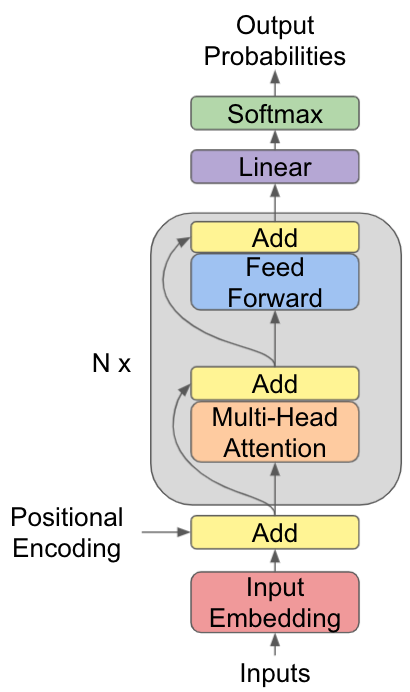

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device type', DEVICE)

device type cuda


In [119]:
N_TOKENS = 16
SEQ_LEN = 64

MAX_COUNT = 9
OUTPUT_DIM = MAX_COUNT + 1

def get_single_example(n_tokens=None, seqlen=None):
  if n_tokens is None:
    n_tokens = N_TOKENS
  if seqlen is None:
    seqlen = SEQ_LEN
  seq = np.random.randint(low=0, high=n_tokens, size=(seqlen,))
  label = [min(list(seq[:i]).count(seq[i]), MAX_COUNT) for i, x in enumerate(seq)]
  label = np.array(label)
  return seq, label

seq, label = get_single_example()
print('Sequence:', seq)
print('Labels:', label)
print('Sequence and labels interleaved:\n', np.stack((seq, label)).transpose())

Sequence: [ 4 11  8 14  1  2  2  5  4  8 12  7  0  2  6  4  3  7  1  2  8  7 10 14
 11  3  1  6  7  7 12 11 10  9 15 15  9  7  9  3  5 15  8 13 10  0 10  2
  3  5  1  2  2 12 13  6  5  5  3 11 11  7  8  5]
Labels: [0 0 0 0 0 0 1 0 1 1 0 0 0 2 0 2 0 1 1 3 2 2 0 1 1 1 2 1 3 4 1 2 1 0 0 1 1
 5 2 2 1 2 3 0 2 1 3 4 3 2 3 5 6 2 1 2 3 4 4 3 4 6 4 5]
Sequence and labels interleaved:
 [[ 4  0]
 [11  0]
 [ 8  0]
 [14  0]
 [ 1  0]
 [ 2  0]
 [ 2  1]
 [ 5  0]
 [ 4  1]
 [ 8  1]
 [12  0]
 [ 7  0]
 [ 0  0]
 [ 2  2]
 [ 6  0]
 [ 4  2]
 [ 3  0]
 [ 7  1]
 [ 1  1]
 [ 2  3]
 [ 8  2]
 [ 7  2]
 [10  0]
 [14  1]
 [11  1]
 [ 3  1]
 [ 1  2]
 [ 6  1]
 [ 7  3]
 [ 7  4]
 [12  1]
 [11  2]
 [10  1]
 [ 9  0]
 [15  0]
 [15  1]
 [ 9  1]
 [ 7  5]
 [ 9  2]
 [ 3  2]
 [ 5  1]
 [15  2]
 [ 8  3]
 [13  0]
 [10  2]
 [ 0  1]
 [10  3]
 [ 2  4]
 [ 3  3]
 [ 5  2]
 [ 1  3]
 [ 2  5]
 [ 2  6]
 [12  2]
 [13  1]
 [ 6  2]
 [ 5  3]
 [ 5  4]
 [ 3  4]
 [11  3]
 [11  4]
 [ 7  6]
 [ 8  4]
 [ 5  5]]


In [120]:
t1 = torch.tensor([[0, 1, 2], [3, 4, 5]])
t2 = torch.tensor([[1, 2, 3]])
# torch.einsum('nd, md->nm', t1, t2)
# t1.mm(t2.T)
x, y = t1.shape
x, y

(2, 3)

In [121]:
class Attention(nn.Module):
  def __init__(self, hidden_dim, num_heads):
    super(Attention, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_heads = num_heads
    self.attentionFilterScale = 1 / (hidden_dim ** .5)

    self.query_lin = nn.Linear(hidden_dim, hidden_dim * num_heads)
    self.key_lin = nn.Linear(hidden_dim, hidden_dim * num_heads)
    self.value_lin = nn.Linear(hidden_dim, hidden_dim * num_heads)

    self.last_lin = nn.Linear(hidden_dim * num_heads, hidden_dim)

  def attention(Q, K, V):
      return nn.Softmax(((Q * K.T) /self.attentionFilterScale) * V)

  def forward(self, x):
    # TODO: implement Attention; return both result of attention mechanism and
    # attention weights (for visualization).
    # x shape: (seqlen, batch, hiddendim)

    seqlen, batch, hiddendim = x.shape
    num_heads, hidden_dim = self.num_heads, self.hidden_dim

    query_lin, key_lin, value_lin, last_lin = self.query_lin, self.key_lin, self.value_lin, self.last_lin
    attention = self.attention

    Q = query_lin(x).reshape(-1, batch, num_heads, hidden_dim)
    K = key_lin(x).reshape(-1, batch, num_heads, hidden_dim)
    V = value_lin(x).reshape(-1, batch, num_heads, hidden_dim)

    # att_weights = F.softmax(((query_lin.weight.data @ key_lin.weight.data.T) / self.attentionFilterScale) @ value_lin.weight.data, dim=1)

    QK = torch.einsum('nbhd,mbhd->bhnm', Q, K)

    result = F.softmax(QK * (self.attentionFilterScale), dim=3)
    att_weights = result
    result = torch.einsum('bhnm,mbhd->nbhd', result, V)
    result = result.reshape(-1, batch, num_heads * hidden_dim)

    result = last_lin(result)

    return result, att_weights

class FeedForward(nn.Module):
  def __init__(self, hidden_dim, d_ff):
    super(FeedForward, self).__init__()
    # TODO: implement FeedForward layer
    self.ff = nn.Sequential(
      nn.Linear(hidden_dim, d_ff),
      nn.ReLU(),
      nn.Linear(d_ff, hidden_dim)
    )

  def forward(self, x):
    # TODO: implement
    # x shape: (seqlen, batch, hiddendim)
    result = self.ff(x)

    return result

class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, d_ff, num_heads, use_attention=True,
               use_feedforward=True):
    super(EncoderLayer, self).__init__()
    # TODO: implement a single encoder layer, using Attention and FeedForward.
    self.attention = Attention(hidden_dim, num_heads)
    self.feedforward = FeedForward(hidden_dim, d_ff)
    self.use_attention = use_attention
    self.use_feedforward = use_feedforward

  def forward(self, x):
    # x shape: (seqlen, batch, hiddendim)
    # TODO: implement a single encoder layer, using Attention and FeedForward.

    result, att_weights = x, None # placeholder

    if self.use_attention:
      add = result
      result, att_weights = self.attention(result)
      result = result + add

    if self.use_feedforward:
      add = result
      result = self.feedforward(result)
      result = result + add

    return result, att_weights

def get_positional_encoding(n_positions, n_dimensions):
  
  positions = torch.arange(0, n_positions, dtype=torch.float).unsqueeze(1)
  div_terms = torch.pow(torch.tensor(10000), torch.arange(0, n_dimensions, 2).float()/n_dimensions)
  
  positional_encoding = np.zeros((n_positions, n_dimensions))

  positional_encoding[:, 0::2] = torch.sin(positions / div_terms)
  positional_encoding[:, 1::2] = torch.cos(positions / div_terms)

  return torch.tensor(positional_encoding, dtype=torch.float, device=DEVICE)

class EncoderModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, d_ff, output_dim, n_layers,
               num_heads, use_attention=True, use_feedforward=True,
               use_positional=True):
    super(EncoderModel, self).__init__()
    
    self._use_positional = use_positional
    self.embedding_layer = nn.Embedding(input_dim, hidden_dim)
    self.layers = nn.ModuleList([
          EncoderLayer(hidden_dim, d_ff, num_heads, use_attention,
                       use_feedforward) for i in range(n_layers)])
    self.output_layer = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, return_att_weights=False):
    # x shape: (seqlen, batch)
    hidden = self.embedding_layer(x)
    # hidden shape: (seqlen, batch, hiddendim)

    if self._use_positional:
      positional_encoding = get_positional_encoding(
          n_positions=hidden.shape[0], n_dimensions=hidden.shape[-1])
      # reshaping to (seqlen, 1, hiddendim)
      positional_encoding = torch.reshape(
          positional_encoding, (hidden.shape[0], 1, hidden.shape[-1]))
      hidden = hidden + positional_encoding
    
    list_att_weights = []
    for layer in self.layers:
      hidden, att_weights = layer(hidden)
      list_att_weights.append(att_weights)
    
    result = self.output_layer(hidden)

    if return_att_weights:
      return result, list_att_weights
    else:
      return result

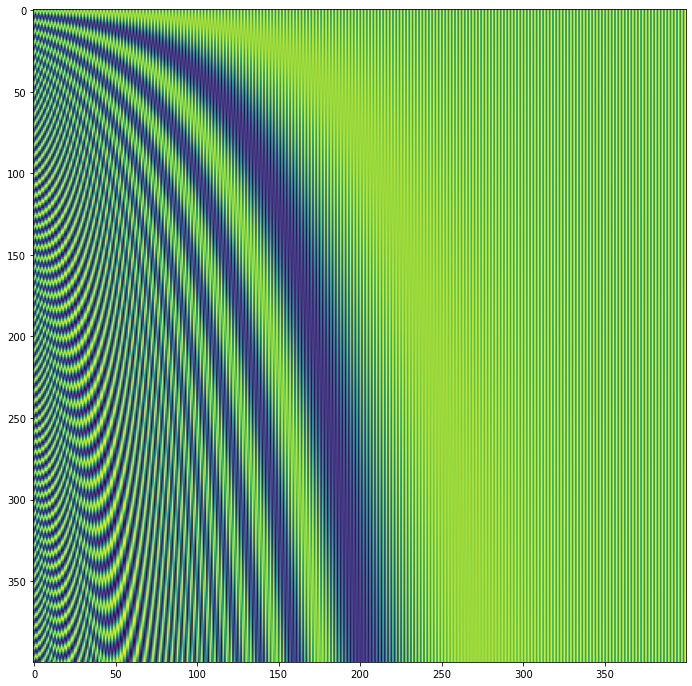

In [122]:
test = get_positional_encoding(400, 400).cpu().numpy()
plt.figure(figsize = (12, 12))
plt.imshow(test)

## This is training loop and test set generation.

In [123]:
TEST_SIZE = 128

test_examples = [get_single_example() for i in range(TEST_SIZE)]

# Transpositions are used, because the convention in PyTorch is to represent
# sequence tensors as <seq_len, batch_size> instead of <batch_size, seq_len>.
test_X = torch.tensor([x[0] for x in test_examples],
                      device=DEVICE).transpose(0, 1)
test_Y = torch.tensor([x[1] for x in test_examples],
                      device=DEVICE).transpose(0, 1)

In [124]:
test_predictions = None
test_attention = None

def train_model(model, lr, num_steps, batch_size):
  model.to(DEVICE)

  start_time = time()
  accs = []
  
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for step in range(num_steps):  
    batch_examples = [get_single_example() for i in range(batch_size)]

    batch_X = torch.tensor([x[0] for x in batch_examples],
                           device=DEVICE
                           ).transpose(0, 1)
    batch_Y = torch.tensor([x[1] for x in batch_examples],
                           device=DEVICE).transpose(0, 1)

    model.train()
    model.zero_grad()
    logits = model(batch_X)
    loss = loss_function(logits.reshape(-1, OUTPUT_DIM), batch_Y.reshape(-1))
    loss.backward()
    optimizer.step()

    if step % (num_steps//100) == 0 or step == num_steps - 1:
      # Printing a summary of the current state of training every 1% of steps.
      model.eval()
      logits, test_attention = model.forward(test_X, return_att_weights=True)
      predicted_logits = logits.reshape(-1, OUTPUT_DIM)

      test_predictions = torch.argmax(predicted_logits, dim=-1)

      test_acc = (
          torch.sum(torch.argmax(predicted_logits, dim=-1) == test_Y.reshape(-1))
          / test_Y.reshape(-1).shape[0])
      
      print('step', step, 'out of', num_steps)
      print('loss train', float(loss))
      print('accuracy test', float(test_acc))
      print()
      accs.append(test_acc)
  print('\nTRAINING TIME:', time()-start_time)
  model.eval()
  return accs, test_predictions, test_attention

## This is example training.

Test your models and visualize attention weights.

step 0 out of 5000
loss train 2.4189672470092773
accuracy test 0.1739501953125

step 50 out of 5000
loss train 1.5986770391464233
accuracy test 0.344482421875

step 100 out of 5000
loss train 1.514265537261963
accuracy test 0.3673095703125

step 150 out of 5000
loss train 1.3839199542999268
accuracy test 0.404296875

step 200 out of 5000
loss train 1.1697726249694824
accuracy test 0.503662109375

step 250 out of 5000
loss train 0.9757862687110901
accuracy test 0.5699462890625

step 300 out of 5000
loss train 0.9213207364082336
accuracy test 0.60302734375

step 350 out of 5000
loss train 0.8339555859565735
accuracy test 0.6336669921875

step 400 out of 5000
loss train 0.7861701250076294
accuracy test 0.66064453125

step 450 out of 5000
loss train 0.7484193444252014
accuracy test 0.6824951171875

step 500 out of 5000
loss train 0.7135438323020935
accuracy test 0.68896484375

step 550 out of 5000
loss train 0.6467295289039612
accuracy test 0.7113037109375

step 600 out of 5000
loss train 

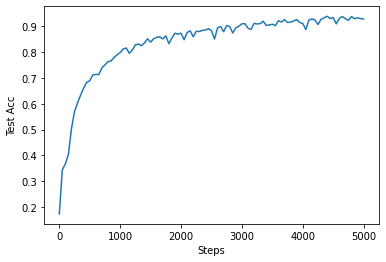

In [125]:
# TODO: change those placeholder parameters
HIDDEN_DIM = 16  # change
FF_DIM = 8  # change
N_HEADS = 4  # change
N_LAYERS = 2  # change

BATCH_SIZE = 100  # change
LR = 0.003  # change
NUM_STEPS = 5000  # change

model = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS)
accs, test_predictions, test_attention = train_model(model, LR, NUM_STEPS, BATCH_SIZE)
plt.plot([i * NUM_STEPS/(len(accs)-1) for i in range(len(accs))], accs)
plt.xlabel('Steps')
plt.ylabel('Test Acc')
plt.show()

In [126]:
id = 0

pred = test_predictions.reshape(-1, TEST_SIZE)[:,id]
true = test_Y[:,id]

print(pred)
print(true)
print()
print(pred - true)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2,
        2, 2, 3, 0, 3, 1, 3, 0, 4, 1, 0, 1, 4, 1, 2, 1, 4, 4, 1, 0, 6, 4, 2, 2,
        5, 2, 3, 6, 2, 3, 5, 4, 2, 7, 3, 4, 4, 5, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 3, 1, 1, 1, 1, 2, 3,
        2, 2, 3, 0, 3, 1, 3, 0, 4, 1, 0, 1, 5, 1, 2, 1, 4, 4, 1, 0, 6, 4, 2, 2,
        5, 2, 3, 6, 2, 3, 5, 4, 2, 7, 3, 4, 4, 5, 0, 1], device='cuda:0')

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, -1,
         0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1,  0], device='cuda:0')


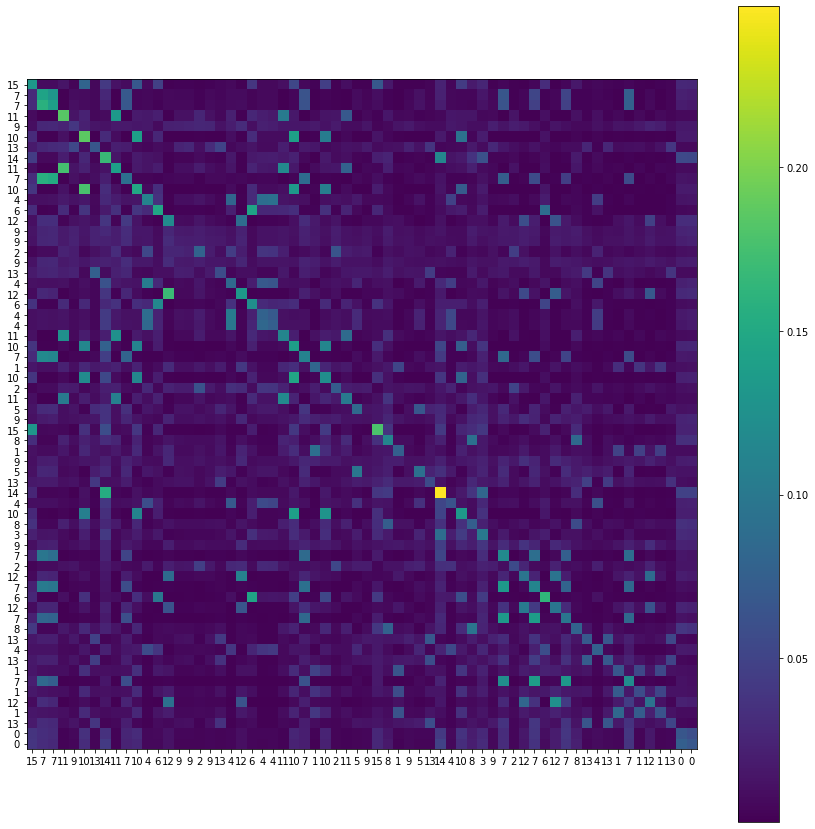

In [137]:
example_x = test_X[:,id]

hid = 1
att_matrix = test_attention[0][id][hid].detach().cpu().numpy()

fig, ax = plt.subplots(1,1, figsize = (15, 15))

img = ax.imshow(att_matrix)

x_label_list = example_x.tolist()
y_label_list = example_x.tolist()

ax.set_xticks(range(64))
ax.set_yticks(range(64))

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)


Widzimy, że atencja skupia się głównie na przecięciach 2 tych samych liczb, w lewej dolnej połowie. Jest to dość intuicyjne biorąc pod uwagę do czego uczony jest model (liczenia wcześniejszych powtórzeń).

Widzimy też, że różne głowy mają różne macierze atencji.

Poniżej atencja tylko dla połowy ciągu

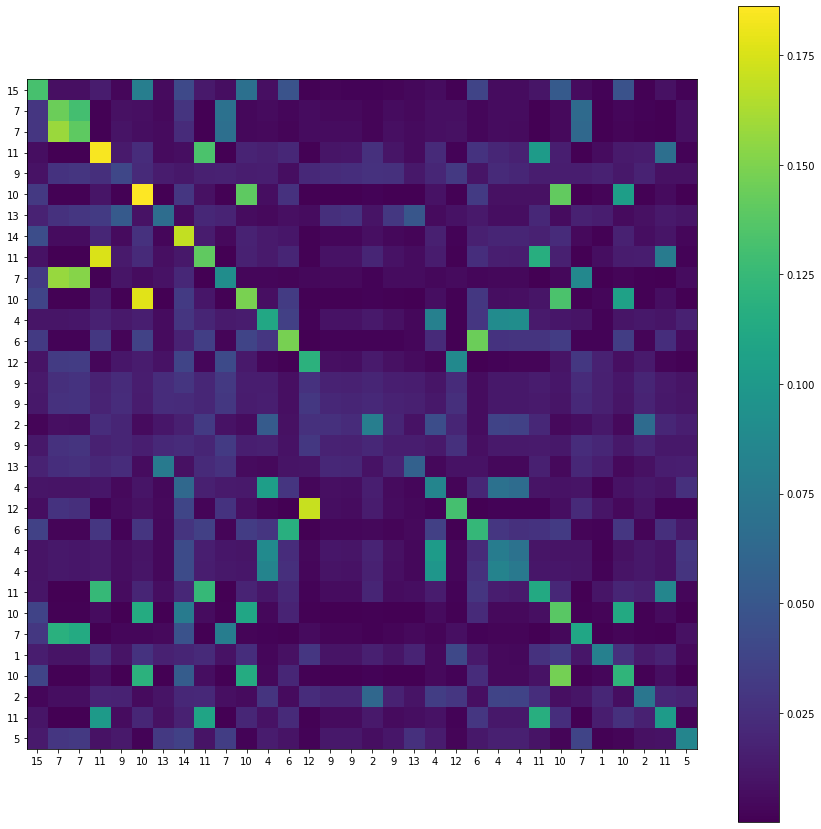

In [138]:
example_x = test_X[:,id]

hid = 1
att_matrix = test_attention[0][id][hid].detach().cpu().numpy()[:32,:32]

fig, ax = plt.subplots(1,1, figsize = (15, 15))

img = ax.imshow(att_matrix)

x_label_list = example_x.tolist()
y_label_list = example_x.tolist()

ax.set_xticks(range(32))
ax.set_yticks(range(32))

ax.set_xticklabels(x_label_list[:32])
ax.set_yticklabels(y_label_list[:32])

fig.colorbar(img)

step 0 out of 5000
loss train 2.580754041671753
accuracy test 0.122314453125

step 50 out of 5000
loss train 1.8347444534301758
accuracy test 0.2427978515625

step 100 out of 5000
loss train 1.8326290845870972
accuracy test 0.2437744140625

step 150 out of 5000
loss train 1.7706773281097412
accuracy test 0.2421875

step 200 out of 5000
loss train 1.6983662843704224
accuracy test 0.2464599609375

step 250 out of 5000
loss train 1.6540474891662598
accuracy test 0.2464599609375

step 300 out of 5000
loss train 1.6380791664123535
accuracy test 0.24658203125

step 350 out of 5000
loss train 1.6094228029251099
accuracy test 0.2464599609375

step 400 out of 5000
loss train 1.5837076902389526
accuracy test 0.2464599609375

step 450 out of 5000
loss train 1.5860910415649414
accuracy test 0.2464599609375

step 500 out of 5000
loss train 1.5789048671722412
accuracy test 0.24658203125

step 550 out of 5000
loss train 1.5692237615585327
accuracy test 0.246337890625

step 600 out of 5000
loss train 

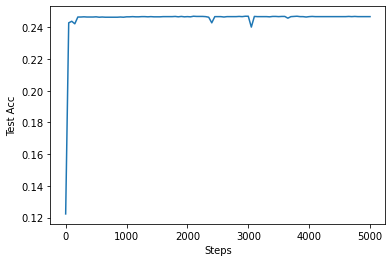

In [129]:
# Without positional encoding
HIDDEN_DIM = 16  # change
FF_DIM = 8  # change
N_HEADS = 4  # change
N_LAYERS = 2  # change

BATCH_SIZE = 100  # change
LR = 0.003  # change
NUM_STEPS = 5000  # change

model2 = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS, use_attention=True, use_feedforward=True,
               use_positional=False)
accs, test_predictions, test_acc = train_model(model2, LR, NUM_STEPS, BATCH_SIZE)
plt.plot([i * NUM_STEPS/(len(accs)-1) for i in range(len(accs))], accs)
plt.xlabel('Steps')
plt.ylabel('Test Acc')
plt.show()

In [130]:
id = 0

pred = test_predictions.reshape(-1, TEST_SIZE)[:, id]
true = test_Y[:,id]

print(pred)
print(true)
print()
print(pred - true)

tensor([0, 1, 1, 2, 1, 3, 0, 0, 2, 1, 3, 4, 2, 3, 1, 1, 1, 1, 0, 4, 3, 2, 4, 4,
        2, 3, 1, 3, 3, 1, 2, 0, 1, 0, 0, 3, 1, 0, 0, 0, 4, 3, 0, 0, 1, 1, 1, 3,
        1, 2, 3, 1, 0, 0, 4, 0, 3, 1, 3, 3, 3, 0, 0, 0], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 3, 1, 1, 1, 1, 2, 3,
        2, 2, 3, 0, 3, 1, 3, 0, 4, 1, 0, 1, 5, 1, 2, 1, 4, 4, 1, 0, 6, 4, 2, 2,
        5, 2, 3, 6, 2, 3, 5, 4, 2, 7, 3, 4, 4, 5, 0, 1], device='cuda:0')

tensor([ 0,  1,  0,  2,  1,  3,  0,  0,  1, -1,  2,  4,  2,  3,  0, -1,  1, -2,
        -1,  3,  2,  1,  2,  1,  0,  1, -2,  3,  0,  0, -1,  0, -3, -1,  0,  2,
        -4, -1, -2, -1,  0, -1, -1,  0, -5, -3, -1,  1, -4,  0,  0, -5, -2, -3,
        -1, -4,  1, -6,  0, -1, -1, -5,  0, -1], device='cuda:0')


Widzimy, że model nie uczy się powyżej ~25%. Dzieje się tak, ponieważ nie bierze pod uwagę kolejności tokenów. Przewiduje jednak w miare małe liczby, ponieważ mniejsze liczby zdarzają się częściej

step 0 out of 5000
loss train 2.5274834632873535
accuracy test 0.0782470703125

step 50 out of 5000
loss train 1.7028995752334595
accuracy test 0.323974609375

step 100 out of 5000
loss train 1.577394962310791
accuracy test 0.3563232421875

step 150 out of 5000
loss train 1.5351332426071167
accuracy test 0.36328125

step 200 out of 5000
loss train 1.5030534267425537
accuracy test 0.3651123046875

step 250 out of 5000
loss train 1.5374505519866943
accuracy test 0.3642578125

step 300 out of 5000
loss train 1.5099846124649048
accuracy test 0.364013671875

step 350 out of 5000
loss train 1.5007355213165283
accuracy test 0.3607177734375

step 400 out of 5000
loss train 1.5177404880523682
accuracy test 0.3619384765625

step 450 out of 5000
loss train 1.527309775352478
accuracy test 0.3636474609375

step 500 out of 5000
loss train 1.5309563875198364
accuracy test 0.3603515625

step 550 out of 5000
loss train 1.4947752952575684
accuracy test 0.3624267578125

step 600 out of 5000
loss train 1.

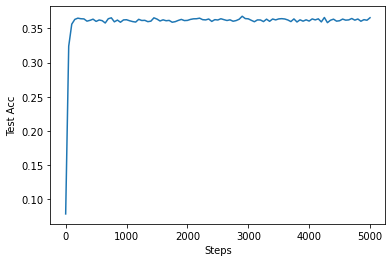

In [131]:
# Without attention
HIDDEN_DIM = 16  # change
FF_DIM = 8  # change
N_HEADS = 4  # change
N_LAYERS = 2  # change

BATCH_SIZE = 100  # change
LR = 0.003  # change
NUM_STEPS = 5000  # change

model3 = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS, use_attention=False, use_feedforward=True,
               use_positional=True)
accs, test_predictions, test_acc = train_model(model3, LR, NUM_STEPS, BATCH_SIZE)
plt.plot([i * NUM_STEPS/(len(accs)-1) for i in range(len(accs))], accs)
plt.xlabel('Steps')
plt.ylabel('Test Acc')
plt.show()

In [132]:
id = 0

pred = test_predictions.reshape(-1, TEST_SIZE)[:, id]
true = test_Y[:,id]

print(pred)
print(true)
print()
print(pred - true)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 3, 1, 1, 1, 1, 2, 3,
        2, 2, 3, 0, 3, 1, 3, 0, 4, 1, 0, 1, 5, 1, 2, 1, 4, 4, 1, 0, 6, 4, 2, 2,
        5, 2, 3, 6, 2, 3, 5, 4, 2, 7, 3, 4, 4, 5, 0, 1], device='cuda:0')

tensor([ 0,  0, -1,  0,  0,  0,  0,  0, -1, -2, -1,  0,  0,  0,  0, -1,  1, -2,
         0,  0,  0,  0, -1, -2, -1, -1, -2,  1, -2,  0, -2,  1, -2,  1,  2,  1,
        -3,  1,  0,  1, -2, -2,  1,  2, -4, -2,  0,  0, -2,  1,  0, -3,  1,  0,
        -2, -1,  1, -4,  0, -1, -1, -2,  3,  2], device='cuda:0')


Z uwagi na brak atencji model osiąga tylkoo ~36%. Bierze on pod uwagę jedynie pozycje tokenów ale nie ma wybiórczej atencji co do ich wartości. Dlatego na początku przewiduje mniejsze liczby a później coraz większe bo tak też wyglądają rzeczywiste dane.

step 0 out of 5000
loss train 2.5100324153900146
accuracy test 0.1199951171875

step 50 out of 5000
loss train 1.593848466873169
accuracy test 0.3450927734375

step 100 out of 5000
loss train 1.5203347206115723
accuracy test 0.360107421875

step 150 out of 5000
loss train 1.4222908020019531
accuracy test 0.4046630859375

step 200 out of 5000
loss train 1.2828688621520996
accuracy test 0.4580078125

step 250 out of 5000
loss train 1.174475908279419
accuracy test 0.50830078125

step 300 out of 5000
loss train 1.0782251358032227
accuracy test 0.54638671875

step 350 out of 5000
loss train 0.9914484620094299
accuracy test 0.572265625

step 400 out of 5000
loss train 0.939409613609314
accuracy test 0.6107177734375

step 450 out of 5000
loss train 0.8644987344741821
accuracy test 0.626220703125

step 500 out of 5000
loss train 0.8164922595024109
accuracy test 0.6485595703125

step 550 out of 5000
loss train 0.7956640720367432
accuracy test 0.664794921875

step 600 out of 5000
loss train 0.75

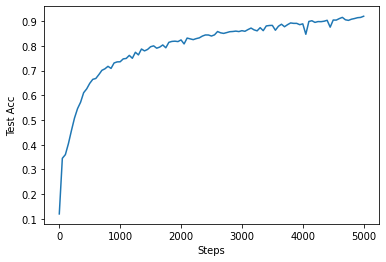

In [133]:
# Without feed_forward
HIDDEN_DIM = 16  # change
FF_DIM = 8  # change
N_HEADS = 4  # change
N_LAYERS = 2  # change

BATCH_SIZE = 100  # change
LR = 0.003  # change
NUM_STEPS = 5000  # change

model4 = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS, use_attention=True, use_feedforward=False,
               use_positional=True)
accs, test_predictions, test_acc = train_model(model4, LR, NUM_STEPS, BATCH_SIZE)
plt.plot([i * NUM_STEPS/(len(accs)-1) for i in range(len(accs))], accs)
plt.xlabel('Steps')
plt.ylabel('Test Acc')
plt.show()

In [134]:
id = 0

pred = test_predictions.reshape(-1, TEST_SIZE)[:, id]
true = test_Y[:,id]

print(pred)
print(true)
print()
print(pred - true)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 0, 3, 1, 1, 1, 1, 2, 2,
        2, 2, 3, 0, 3, 1, 3, 0, 4, 1, 0, 1, 5, 1, 2, 1, 4, 4, 1, 0, 6, 4, 2, 2,
        5, 2, 3, 6, 2, 3, 5, 4, 2, 7, 3, 4, 3, 5, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 3, 1, 1, 1, 1, 2, 3,
        2, 2, 3, 0, 3, 1, 3, 0, 4, 1, 0, 1, 5, 1, 2, 1, 4, 4, 1, 0, 6, 4, 2, 2,
        5, 2, 3, 6, 2, 3, 5, 4, 2, 7, 3, 4, 4, 5, 0, 1], device='cuda:0')

tensor([ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, -1,  0,  1,  0], device='cuda:0')


Bez FeedForwawrd model uczy się prawidłowo, i tylko nieco gorzej. Prawdopodobnie jest to spowodowane małą trudnością problemu. W przypadku trudniejszych problemów różnica mogłaby być bardziej zauważalna.

step 0 out of 5000
loss train 2.6666274070739746
accuracy test 0.070068359375

step 50 out of 5000
loss train 1.8753352165222168
accuracy test 0.2379150390625

step 100 out of 5000
loss train 1.8486695289611816
accuracy test 0.2431640625

step 150 out of 5000
loss train 1.8384160995483398
accuracy test 0.2454833984375

step 200 out of 5000
loss train 1.828787088394165
accuracy test 0.2467041015625

step 250 out of 5000
loss train 1.8304224014282227
accuracy test 0.2467041015625

step 300 out of 5000
loss train 1.838951826095581
accuracy test 0.2467041015625

step 350 out of 5000
loss train 1.8372526168823242
accuracy test 0.2467041015625

step 400 out of 5000
loss train 1.8399767875671387
accuracy test 0.2467041015625

step 450 out of 5000
loss train 1.8530775308609009
accuracy test 0.2467041015625

step 500 out of 5000
loss train 1.816233515739441
accuracy test 0.2467041015625

step 550 out of 5000
loss train 1.830520510673523
accuracy test 0.2467041015625

step 600 out of 5000
loss t

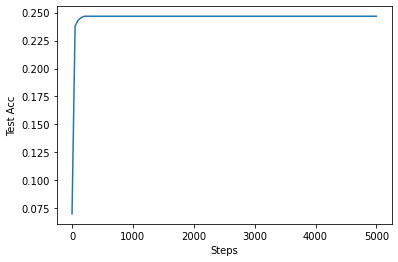

In [135]:
# Without positional encoding and attention
HIDDEN_DIM = 16  # change
FF_DIM = 8  # change
N_HEADS = 4  # change
N_LAYERS = 2  # change

BATCH_SIZE = 100  # change
LR = 0.003  # change
NUM_STEPS = 5000  # change

model5 = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS, use_attention=False, use_feedforward=True,
               use_positional=False)
accs, test_predictions, test_acc =  train_model(model5, LR, NUM_STEPS, BATCH_SIZE)
plt.plot([i * NUM_STEPS/(len(accs)-1) for i in range(len(accs))], accs)
plt.xlabel('Steps')
plt.ylabel('Test Acc')
plt.show()

In [136]:
id = 0

pred = test_predictions.reshape(-1, TEST_SIZE)[:, id]
true = test_Y[:,id]

print(pred)
print(true)
print()
print(pred - true)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 3, 1, 1, 1, 1, 2, 3,
        2, 2, 3, 0, 3, 1, 3, 0, 4, 1, 0, 1, 5, 1, 2, 1, 4, 4, 1, 0, 6, 4, 2, 2,
        5, 2, 3, 6, 2, 3, 5, 4, 2, 7, 3, 4, 4, 5, 0, 1], device='cuda:0')

tensor([ 0,  0, -1,  0,  0,  0,  0,  0, -1, -2, -1,  0,  0,  0, -1, -2,  0, -3,
        -1, -1, -1, -1, -2, -3, -2, -2, -3,  0, -3, -1, -3,  0, -4, -1,  0, -1,
        -5, -1, -2, -1, -4, -4, -1,  0, -6, -4, -2, -2, -5, -2, -3, -6, -2, -3,
        -5, -4, -2, -7, -3, -4, -4, -5,  0, -1], device='cuda:0')


bez atencji i positional encodingu model osiąga około ~25% accuracy. Nie bierze pod uwagę kolejności tokenów i nie ma wybiórczej uwagi co do ich wartości. Zagubiony model zwraca same zera ponieważ one występują w danych najczęściej. I w ~25% zgaduje poprawną liczbę powtórzeń